# Classification with PyTorch

In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Data (create and prepare)

In [ ]:
import sklearn
from sklearn.datasets import make_circles
# Make 1000 samples
X, y=make_circles(1000, noise=0.03, random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data
circles=pd.DataFrame({"X1":X[:, 0],
                      "X2": X[:, 1],
                      "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [ ]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

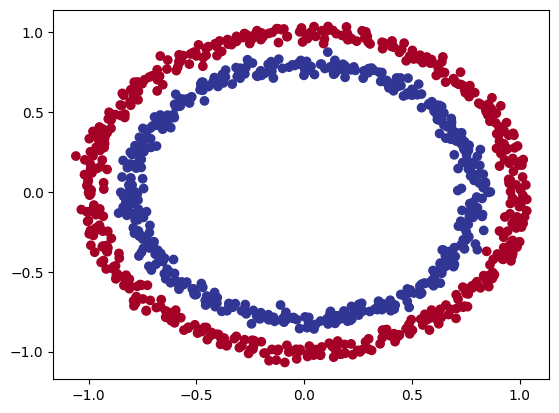

In [ ]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### turn data into tensors + train/test splits

In [ ]:
# Turn data into tensors
X=torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model

In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [ ]:
class Circle_Model_V0(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear_layer_1=nn.Linear(in_features=2, out_features=5)
    self.linear_layer_2=nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.linear_layer_2(self.linear_layer_1(x))

model_0=Circle_Model_V0().to(device)
model_0.state_dict()

OrderedDict([('linear_layer_1.weight',
              tensor([[ 0.4958, -0.0854],
                      [-0.5104,  0.1375],
                      [ 0.2833,  0.4982],
                      [-0.3556, -0.2509],
                      [ 0.2073,  0.3989]])),
             ('linear_layer_1.bias',
              tensor([ 0.2628,  0.3131, -0.3698,  0.3611, -0.2279])),
             ('linear_layer_2.weight',
              tensor([[-0.2529, -0.0361,  0.1648,  0.2954,  0.1567]])),
             ('linear_layer_2.bias', tensor([-0.2772]))])

In [ ]:
model_0=nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2560, -0.1129],
                      [-0.0023,  0.3881],
                      [-0.0975,  0.3910],
                      [-0.1957, -0.6341],
                      [-0.0654, -0.3522]])),
             ('0.bias', tensor([-0.3916,  0.6860,  0.2032,  0.4421,  0.4635])),
             ('1.weight',
              tensor([[ 0.0936, -0.4008,  0.0113, -0.0149, -0.1824]])),
             ('1.bias', tensor([0.1961]))])

In [ ]:
torch.manual_seed(42)

#setup loss function
loss_fn=nn.BCEWithLogitsLoss() #Binary crossentropy loss

#setup optimizer
optimizer=torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

##3. Train Model

model produces Logits, they have to be turned into prediction probabilities by passing them through a sigmoid function (for binary classification)


In [ ]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2788],
        [-0.2882],
        [-0.2037],
        [-0.3003],
        [-0.1233]])

In [ ]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4307],
        [0.4285],
        [0.4493],
        [0.4255],
        [0.4692]])

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

In [ ]:
#training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=100

X_train, y_train=X_train.to(device), y_train.to(device)
X_test, y_test=X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits=model_0(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  loss=loss_fn(y_logits, y_train)
  accuracy=accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

#testing loop

  model_0.eval()

  with torch.inference_mode():
    test_logits=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    test_loss=loss_fn(test_logits, y_test)
    test_accuracy=accuracy_fn(y_test, test_pred)

  if epoch % 10 ==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {accuracy:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")

Epoch: 0 | Loss: 0.69914, Acc: 50.00% | Test loss: 0.69704, Test acc: 50.00%
Epoch: 10 | Loss: 0.69548, Acc: 50.00% | Test loss: 0.69380, Test acc: 50.00%
Epoch: 20 | Loss: 0.69424, Acc: 44.88% | Test loss: 0.69284, Test acc: 45.00%
Epoch: 30 | Loss: 0.69376, Acc: 46.00% | Test loss: 0.69261, Test acc: 48.00%
Epoch: 40 | Loss: 0.69354, Acc: 47.75% | Test loss: 0.69263, Test acc: 48.00%
Epoch: 50 | Loss: 0.69341, Acc: 48.12% | Test loss: 0.69273, Test acc: 50.50%
Epoch: 60 | Loss: 0.69333, Acc: 48.75% | Test loss: 0.69286, Test acc: 48.00%
Epoch: 70 | Loss: 0.69326, Acc: 48.75% | Test loss: 0.69299, Test acc: 47.50%
Epoch: 80 | Loss: 0.69321, Acc: 50.75% | Test loss: 0.69313, Test acc: 45.50%
Epoch: 90 | Loss: 0.69317, Acc: 50.00% | Test loss: 0.69325, Test acc: 49.50%


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py

--2024-01-19 11:14:22--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10160 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.92K  --.-KB/s    in 0s      

2024-01-19 11:14:22 (62.8 MB/s) - ‘helper_functions.py’ saved [10160/10160]



In [ ]:
from helper_functions import *

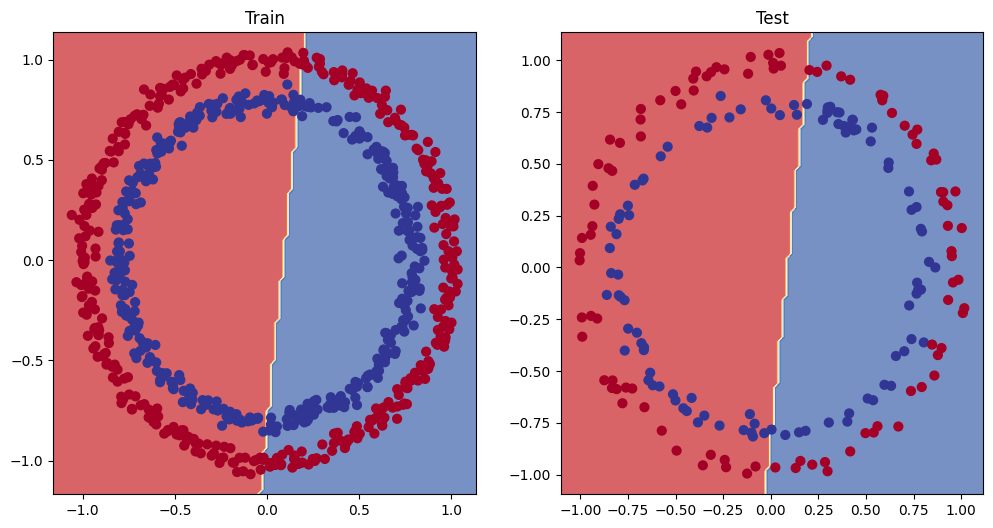

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## create a model with more layers and more hidden units and check for improvement

In [ ]:
class Circle_Model_V1(nn.Module):
  def __init__(self):
    super().__init__()

    self.Layer1=nn.Linear(in_features=2, out_features=10)

    self.Layer2=nn.Linear(in_features=10, out_features=10)

    self.Layer3=nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.Layer3(self.Layer2(self.Layer1(x)))

model_1= Circle_Model_V1().to(device)
model_1

Circle_Model_V1(
  (Layer1): Linear(in_features=2, out_features=10, bias=True)
  (Layer2): Linear(in_features=10, out_features=10, bias=True)
  (Layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [ ]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> prediction labels

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


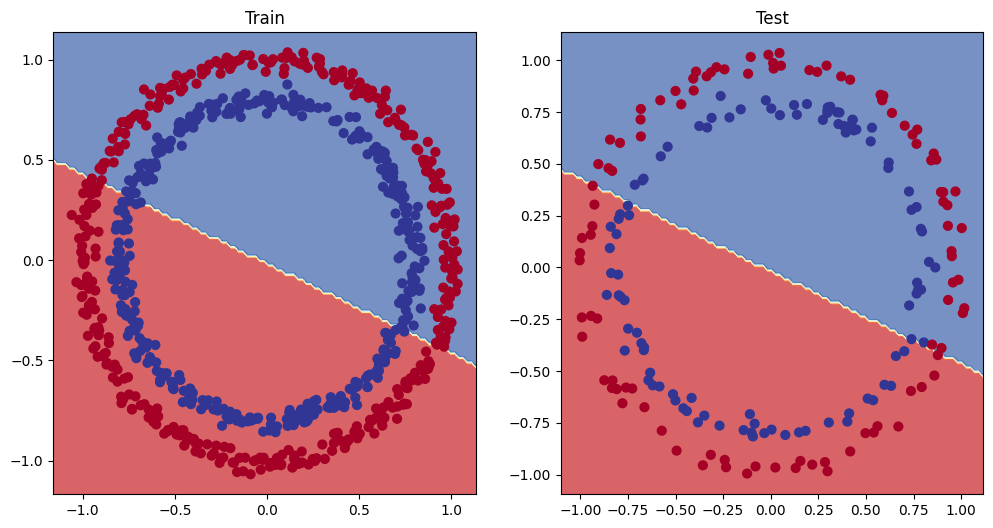

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## Preparing data to see if the model can fit a straight line

In [ ]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

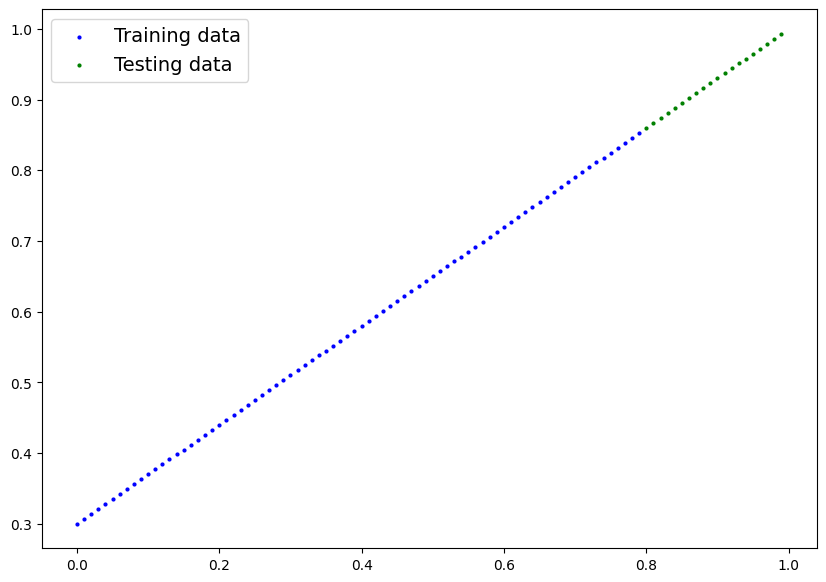

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

### Adjusting model_1 to fit a straight line

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss() # MAE loss with regression data
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [ ]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


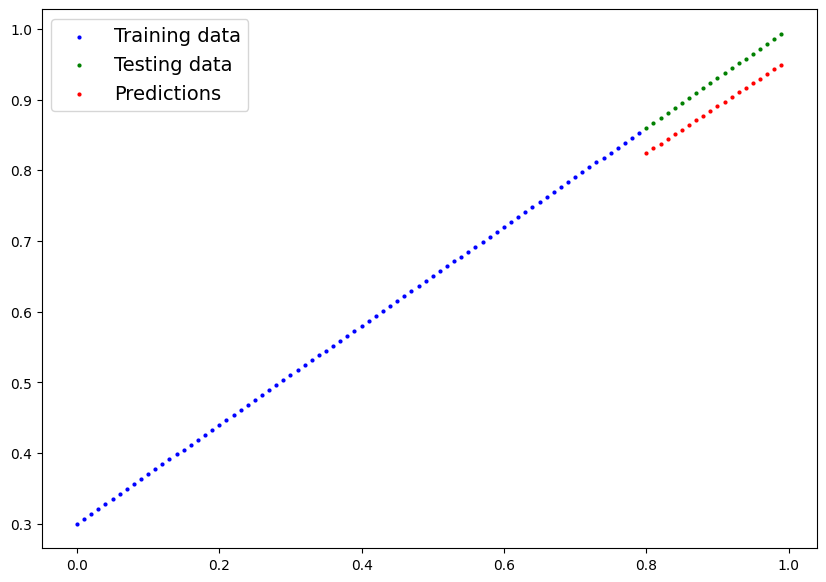

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## Introducing Non-Linearity

In [ ]:
class Circle_Model_V3(nn.Module):
  def __init__(self):
    super().__init__()

    self.Layer1=nn.Linear(in_features=2, out_features=10)
    self.activation1=nn.ReLU()

    self.Layer2=nn.Linear(in_features=10, out_features=10)
    self.activation2=nn.ReLU()

    self.Layer3=nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.Layer3(self.activation2(self.Layer2(self.activation1(self.Layer1(x)))))

model_3= Circle_Model_V3().to(device)
model_3

Circle_Model_V3(
  (Layer1): Linear(in_features=2, out_features=10, bias=True)
  (activation1): ReLU()
  (Layer2): Linear(in_features=10, out_features=10, bias=True)
  (activation2): ReLU()
  (Layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_3.parameters(), lr=0.15)

In [ ]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_3.train()
  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> prediction labels

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69316, Test acc: 50.00%
Epoch: 100 | Loss: 0.69050, Acc: 52.88% | Test loss: 0.69026, Test acc: 55.00%
Epoch: 200 | Loss: 0.68795, Acc: 53.00% | Test loss: 0.68722, Test acc: 56.00%
Epoch: 300 | Loss: 0.68327, Acc: 52.75% | Test loss: 0.68197, Test acc: 56.00%
Epoch: 400 | Loss: 0.67517, Acc: 54.37% | Test loss: 0.67284, Test acc: 56.50%
Epoch: 500 | Loss: 0.65995, Acc: 61.25% | Test loss: 0.65603, Test acc: 63.00%
Epoch: 600 | Loss: 0.62385, Acc: 74.00% | Test loss: 0.62148, Test acc: 79.00%
Epoch: 700 | Loss: 0.52910, Acc: 91.38% | Test loss: 0.53965, Test acc: 89.50%
Epoch: 800 | Loss: 0.37147, Acc: 97.75% | Test loss: 0.40622, Test acc: 92.00%
Epoch: 900 | Loss: 0.20867, Acc: 99.50% | Test loss: 0.25826, Test acc: 97.50%


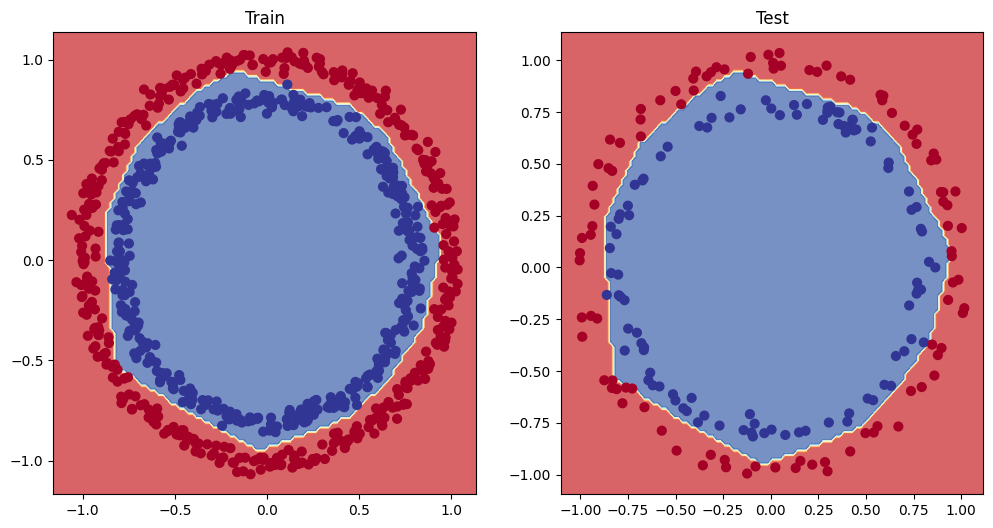

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## Multiclass classification

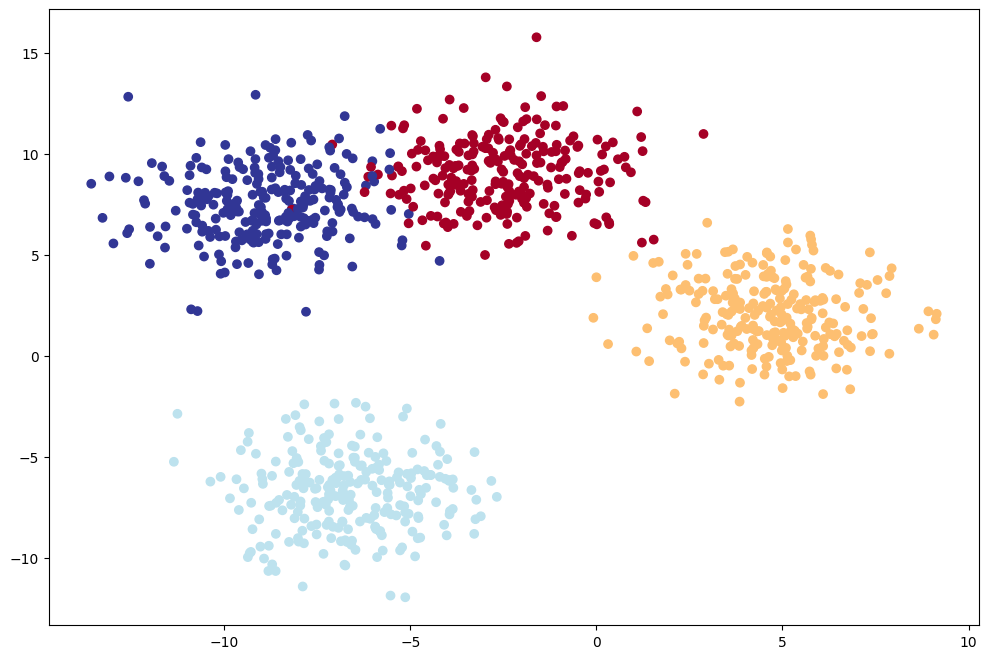

In [ ]:
# create dataset
from sklearn.datasets import make_blobs

NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42

X_blob, y_blob= make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.75, random_state=RANDOM_SEED)

X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test=train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)
len(X_blob_train), len(y_blob_train)

plt.figure(figsize=(12, 8))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [ ]:
model_4=nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=4)
).to(device)
model_4


Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=4, bias=True)
)

In [ ]:
#create loss function
loss_fn=nn.CrossEntropyLoss()

#create optimizer
optimizer=torch.optim.SGD(params=model_4.parameters(), lr=0.15)

In [ ]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.1629, Acc: 40.25% | Test loss: 1.0447, Test acc: 51.50%
Epoch: 10 | Loss: 0.5523, Acc: 96.25% | Test loss: 0.5531, Test acc: 96.00%
Epoch: 20 | Loss: 0.2919, Acc: 97.88% | Test loss: 0.2771, Test acc: 99.00%
Epoch: 30 | Loss: 0.1145, Acc: 98.12% | Test loss: 0.1012, Test acc: 99.00%
Epoch: 40 | Loss: 0.0786, Acc: 98.12% | Test loss: 0.0672, Test acc: 99.00%
Epoch: 50 | Loss: 0.0680, Acc: 98.12% | Test loss: 0.0562, Test acc: 99.00%
Epoch: 60 | Loss: 0.0631, Acc: 98.12% | Test loss: 0.0509, Test acc: 99.00%
Epoch: 70 | Loss: 0.0604, Acc: 98.12% | Test loss: 0.0479, Test acc: 99.00%
Epoch: 80 | Loss: 0.0587, Acc: 98.12% | Test loss: 0.0459, Test acc: 99.00%
Epoch: 90 | Loss: 0.0575, Acc: 98.12% | Test loss: 0.0445, Test acc: 99.00%


In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ -0.2794,   6.9280,  -8.8311,  -9.3316],
        [ -1.8942,  -6.8650,  -4.5185,   3.3909],
        [ -3.8920,  -4.2772,   3.6466,  -2.9652],
        [ -1.2836,   4.8517,  -4.1157,  -5.0283],
        [  4.3746,  -1.3632, -10.6122,  -7.3147],
        [ -2.6405,  -8.3615,  -5.3614,   4.3818],
        [ -3.3881,  -3.5641,   3.1911,  -2.4015],
        [  3.7001,  -4.7558,  -7.8061,  -3.3080],
        [ -5.0848,  -5.6590,   4.5240,  -3.9411],
        [  4.0464,  -3.4941,  -8.5606,  -4.6053]])

In [ ]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[7.4052e-04, 9.9926e-01, 1.4308e-07, 8.6736e-08],
        [5.0393e-03, 3.4960e-05, 3.6528e-04, 9.9456e-01],
        [5.3094e-04, 3.6121e-04, 9.9777e-01, 1.3413e-03],
        [2.1600e-03, 9.9766e-01, 1.2720e-04, 5.1068e-05],
        [9.9678e-01, 3.2116e-03, 3.0897e-07, 8.3568e-06],
        [8.9093e-04, 2.9192e-06, 5.8635e-05, 9.9905e-01],
        [1.3802e-03, 1.1575e-03, 9.9376e-01, 3.7019e-03],
        [9.9887e-01, 2.1240e-04, 1.0056e-05, 9.0351e-04],
        [6.7115e-05, 3.7795e-05, 9.9968e-01, 2.1063e-04],
        [9.9929e-01, 5.3076e-04, 3.3462e-06, 1.7470e-04]])

In [ ]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

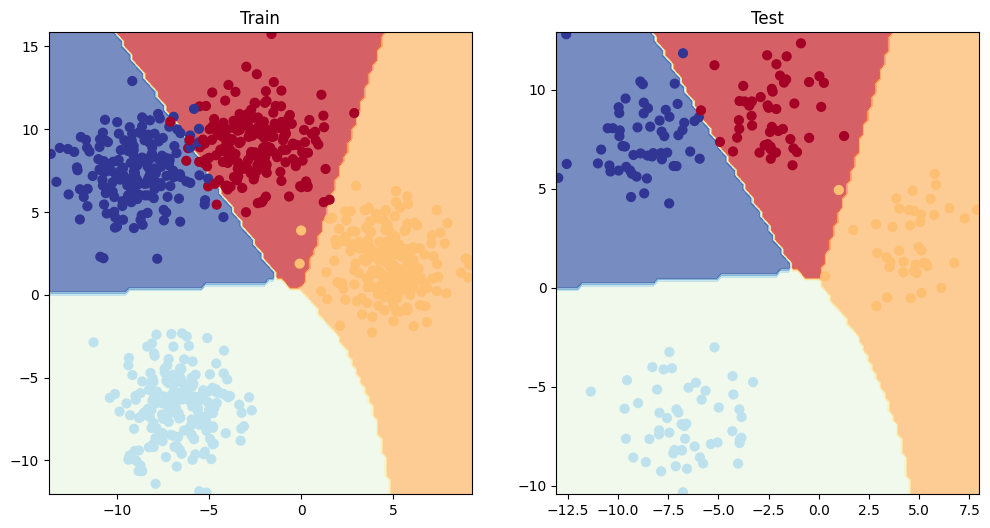

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)